In [52]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from google_play_scraper import app, Sort, reviews_all, search, reviews
from app_store_scraper import AppStore
import sys
import openai
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import os
from dotenv import load_dotenv

In [53]:
country = 'us'

iOS_app_name = 'facebook'
iOS_app_id = '284882215'

android_app_name = 'com.facebook.katana'

## iOS

In [54]:
try:
    if iOS_app_name != '':
        info = AppStore(app_name = iOS_app_name,
                        app_id = iOS_app_id,
                        country = country)
        
        # Send a GET request to the URL
        response = requests.get(info.url)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')

            # Find all elements containing the word "userName" in the text within review_elements
            review_elements = soup.find_all(lambda tag: tag and "userName" in tag.text)

            # If there are review elements found, proceed to fetch reviews
            if review_elements:                    
                info.review(how_many=1000)
                
                iOS_reviews = pd.DataFrame(info.reviews)
                
                iOS_reviews['reviewId'] = iOS_reviews['userName'].astype(str) + "-" + iOS_reviews['date'].astype(str)
        
                iOS_reviews['store'] = 'iOS Store'

            else:
                print("This app has no reviews.")

        else:
            print(f"Failed to fetch data. Status code: {response.status_code}")

    else:
        pass    
except:
    pass

2024-08-12 20:23:29,808 [INFO] Base - Initialised: AppStore('us', 'facebook', 284882215)
2024-08-12 20:23:29,809 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/facebook/id284882215
2024-08-12 20:23:34,970 [INFO] Base - [id:284882215] Fetched 180 reviews (180 fetched in total)
2024-08-12 20:23:41,089 [INFO] Base - [id:284882215] Fetched 340 reviews (340 fetched in total)
2024-08-12 20:24:02,105 [INFO] Base - [id:284882215] Fetched 400 reviews (400 fetched in total)
2024-08-12 20:24:25,864 [INFO] Base - [id:284882215] Fetched 540 reviews (540 fetched in total)
2024-08-12 20:24:50,541 [INFO] Base - [id:284882215] Fetched 720 reviews (720 fetched in total)
2024-08-12 20:25:15,623 [INFO] Base - [id:284882215] Fetched 900 reviews (900 fetched in total)
2024-08-12 20:25:37,948 [INFO] Base - [id:284882215] Fetched 1000 reviews (1000 fetched in total)


## Android

In [55]:
try:
    # Fetch reviews and continuation token
    android_reviews, continuation_token = reviews(
        android_app_name,
        lang = 'en',  # defaults to 'en'
        sort = Sort.NEWEST, # Newest reviews
        count = 1000 # Using 1000 reviews
    )

    android_reviews = pd.DataFrame(android_reviews)

    # Keep wanted columns
    android_reviews.rename(columns={'at': 'date', 'content': 'review', 'score': 'rating'}, inplace=True)
    android_reviews = android_reviews[['reviewId', 'date', 'review', 'rating', 'userName']]
    
    android_reviews['store'] = 'Google Play Store'

    android_reviews.reset_index(inplace=True, drop=True)

except Exception as e:
    print('Error occurred:', e)
    pass

## Combine both datasets

In [56]:
# Combine datasets
reviews_total = pd.concat([iOS_reviews, android_reviews])

# Reset index
reviews_total.reset_index(drop=True, inplace=True)

## Review cleaning

In [57]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Add custom stop words
custom_stop_words = {'app', 'like', 'use', 'Facebook', 'facebook'}
stop_words = stop_words.union(custom_stop_words)

def clean_review(review):
    words = word_tokenize(review.lower())
    # Remove stop words, punctuation and check if all letters are alphabet letters
    cleaned_words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(cleaned_words)

# Apply the cleaning function to each review
reviews_total['cleaned_reviews'] = reviews_total['review'].apply(clean_review)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matefer2006/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matefer2006/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sentiment Analysis

In [58]:
# Load environment variables from the .env file
load_dotenv()

# Get the API key from the environment
openai_api_key = os.getenv('OPENAI_API_KEY')

# Set the OpenAI API key
openai.api_key = openai_api_key

In [59]:
def classify_review(review):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": f"Classify the sentiment in this review in 'Positive', 'Neutral' or 'Negative'. Just one of this three categories and nothing else:\n \"{review}\""}
        ]
    )
    sentiment = response['choices'][0]['message']['content']
    
    return sentiment

In [60]:
# Apply the function to the reviews column
reviews_total['sentiment'] = reviews_total['cleaned_reviews'].apply(classify_review)

reviews_total.fillna('', inplace=True)

In [61]:
openai.api_key = "xxxxx"

# Define a function to classify a review
def classify_review(review):
    response = openai.Completion.create(
        model="gpt-3.5-turbo-instruct",
        prompt=f"Classify the sentiment in this review in 'Positive', 'Neutral' or 'Negative'. Just one of this three categories and nothing else:\n \"{review}\"",
        temperature=0,
        max_tokens=60,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0
    )
    # Extract the sentiment from the response
    sentiment = response.choices[0].text.strip()
    return sentiment

# Apply the function to the reviews column
reviews_total['sentiment'] = reviews_total['cleaned_reviews'].apply(classify_review)

reviews_total.fillna('', inplace=True)

In [62]:
# Correct mislabelled values
reviews_total['sentiment'] = np.where(~reviews_total['sentiment'].isin(['Positive', 'Negative', 'Neutral']), 'Miscellaneous',
                                      reviews_total['sentiment'])

## Plot results

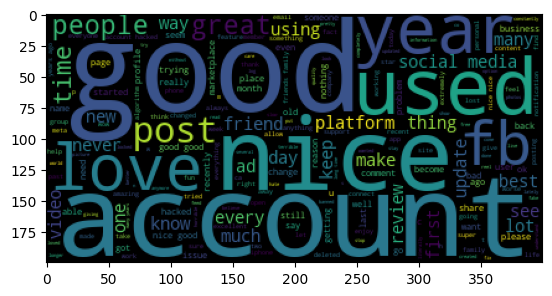

In [64]:
wc = WordCloud().generate(reviews_total['cleaned_reviews'].to_string())
plt.imshow(wc)

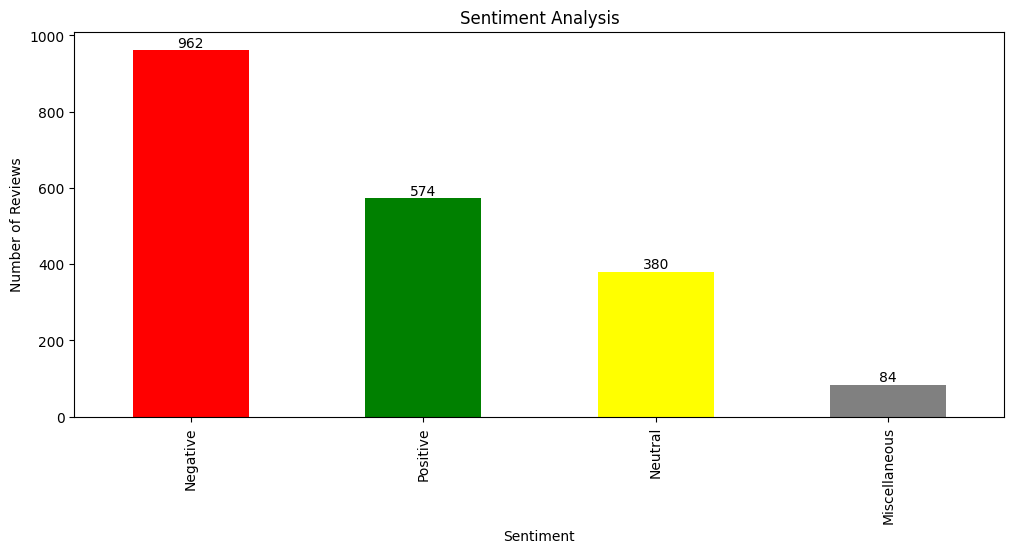

In [65]:
# Define the colors for each sentiment category
colors = {
    'Negative': 'red',
    'Positive': 'green',
    'Neutral': 'yellow',
    'Miscellaneous': 'grey'
}

# Count the sentiment values
sentiment_counts = reviews_total['sentiment'].value_counts()

# Plot the bar chart with custom colors
plt.figure(figsize=(12, 5))
bars = sentiment_counts.plot(kind='bar', color=[colors.get(sentiment, 'black') for sentiment in sentiment_counts.index])

# Add data labels on top of the bars
for bar in bars.containers[0]:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height)}', ha='center', va='bottom')

# Set plot title and labels
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')

plt.show()

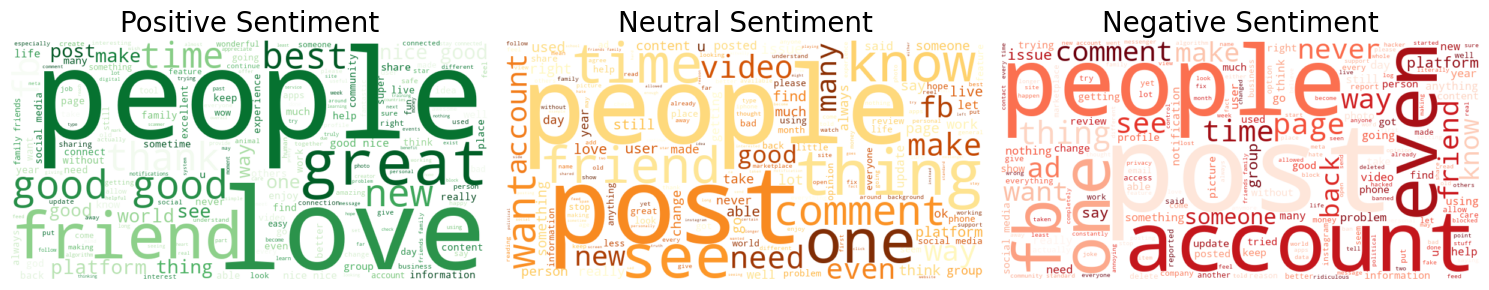

In [66]:
# Separate the reviews based on sentiment
positive_reviews = " ".join(reviews_total[reviews_total['sentiment'] == 'Positive']['cleaned_reviews'])
neutral_reviews = " ".join(reviews_total[reviews_total['sentiment'] == 'Neutral']['cleaned_reviews'])
negative_reviews = " ".join(reviews_total[reviews_total['sentiment'] == 'Negative']['cleaned_reviews'])

# Create word clouds for each sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_reviews)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='YlOrBr').generate(neutral_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_reviews)

# Plot the word clouds
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment', fontsize=20)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Sentiment', fontsize=20)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment', fontsize=20)
plt.axis('off')

plt.tight_layout()
plt.show()
